# Ensemble Learning through Pasting 

**Pasting == Bootstrapping Aggregation W/O replacement** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import MaxCallStochasticModel
from aggregating.models import SimplePaster
from visualisations import *

## Parameter Configuration

In [12]:
np.random.seed(2020)

In [13]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [14]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [15]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [16]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [17]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0793534441124991

In [18]:
X_test.shape

(50000, 1, 2)

## Create Custom Models
(to have more control of splitting etc)

In [19]:
from aggregating.models import SimpleBagger
s = SimplePaster(11,0.5,None)
s.get_params()

{'M': 11, 'predictor': None, 'train_size_alpha': 0.5}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [20]:
#reference:
from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

hyperparams= {'M':1, 'train_size_alpha':1.0} #baseline!
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],5,N_test,MaxCallStochasticModel,V_0)
print(reference_error)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 18932
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.11407985929668751
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.17015733736962088
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.14168741965485387
{'M': 1, 'train_size_alpha': 1.0} , 3 -> 0.12078310441440153
{'M': 1, 'train_size_alpha': 1.0} , 4 -> 0.1439360532252084
{'M': 1, 'train_size_alpha': 1.0} -> [0.11407985929668751, 0.17015733736962088, 0.14168741965485387, 0.12078310441440153, 0.1439360532252084]
[0.11407985929668751, 0.17015733736962088, 0.14168741965485387, 0.12078310441440153, 0.1439360532252084]


In [21]:
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

0.13812875479215445


In [22]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SimpleBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 3
M_grid = [1,3,5,7,9]
alpha_grid = [0.2,0.3,0.4,0.5]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(cpu_count()-2) #no allocation issues with mem_efficient_prediction
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel,V_0,None,[2020,2021,2022]),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.2} -> thread id = 24048
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 16792
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.4} -> thread id = 1556
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 9220
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.2} -> thread id = 7200
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.3} -> thread id = 10644
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.4} -> thread id = 22144
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.5} -> thread id = 25312
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.2} -> thread id = 6336
fit
(5000, 2)
 {'M': 5, 'train_size_alpha': 0.3} -> thread id = 6920
fit
(5000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.2} , 0 -> 0.17313162277154423
predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.3} , 0 -> 0.14230661457

predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.2} , 1 -> 0.14808594389678825
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.3} , 1 -> 0.1383183700522313
predict
(50000, 2)
{'M': 7, 'train_size_alpha': 0.4} , 2 -> 0.15155438098391716
{'M': 7, 'train_size_alpha': 0.4} -> [0.1257406416310567, 0.14145635363167186, 0.15155438098391716]
logger {'M': 7, 'train_size_alpha': 0.4}, -> [0.1257406416310567, 0.14145635363167186, 0.15155438098391716]
{'M': 7, 'train_size_alpha': 0.5} , 1 -> 0.168526417566288
{'M': 9, 'train_size_alpha': 0.2} , 2 -> 0.14046566034159885
{'M': 9, 'train_size_alpha': 0.2} -> [0.13499191037632174, 0.14808594389678825, 0.14046566034159885]
logger {'M': 9, 'train_size_alpha': 0.2}, -> [0.13499191037632174, 0.14808594389678825, 0.14046566034159885]
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.5} , 0 -> 0.14179389360791866
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.4} , 1 -> 0.12642598606187117
predict
(50000, 2)
{'M': 9, 'train_size_alpha': 0.3} , 2 -> 0.1

In [23]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.2, [0.17313162277154423, 0.16497798921559212, 0.15026579685216493]]
[1, 0.3, [0.14230661457869873, 0.14649089164607434, 0.14420283680613388]]
[1, 0.4, [0.16531525899052069, 0.15545160203724145, 0.16018577507479276]]
[1, 0.5, [0.1759600573308805, 0.1994861258830614, 0.1992896932962792]]
[3, 0.2, [0.13642943126886284, 0.15689000015939233, 0.1486794899982699]]
[3, 0.3, [0.13062818869859988, 0.15536313745500147, 0.15633229676296412]]
[3, 0.4, [0.1292525674532447, 0.13830215423237757, 0.15658628349200046]]
[3, 0.5, [0.17148612183451814, 0.18341087274789733, 0.19139431753290292]]
[5, 0.2, [0.13380715090211048, 0.14186233076331578, 0.13301585943766128]]
[5, 0.3, [0.13645937963186455, 0.1394214424260486, 0.14218394304753457]]
[5, 0.4, [0.12057771158354585, 0.13042472319155599, 0.14003113831483696]]
[7, 0.3, [0.13001217916542782, 0.1470942819198426, 0.15111931285766894]]
[7, 0.2, [0.13368823779470074, 0.1478410918711787, 0.1404768232551456]]
[5, 0.5, [0.14838034927019356, 0.16368195874464

In [24]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 4)

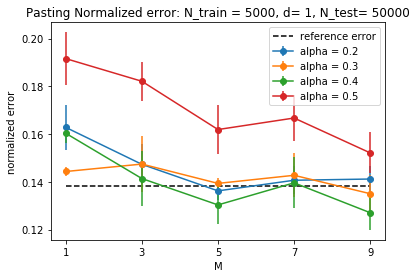

In [31]:
plt.hlines(reference_error_mean,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")

for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Pasting Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend()
plt.savefig("hard_pasting.png")
plt.show()

## Store results

In [29]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [30]:
import json
import datetime
with open(f'hard_pasting{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)

In [34]:
converted_results

array([[[0.17313162, 0.16497799, 0.1502658 ],
        [0.14230661, 0.14649089, 0.14420284],
        [0.16531526, 0.1554516 , 0.16018578],
        [0.17596006, 0.19948613, 0.19928969]],

       [[0.13642943, 0.15689   , 0.14867949],
        [0.13062819, 0.15536314, 0.1563323 ],
        [0.12925257, 0.13830215, 0.15658628],
        [0.17148612, 0.18341087, 0.19139432]],

       [[0.13380715, 0.14186233, 0.13301586],
        [0.13645938, 0.13942144, 0.14218394],
        [0.12057771, 0.13042472, 0.14003114],
        [0.14838035, 0.16368196, 0.17362762]],

       [[0.13368824, 0.14784109, 0.14047682],
        [0.13001218, 0.14709428, 0.15111931],
        [0.12574064, 0.14145635, 0.15155438],
        [0.15436707, 0.16852642, 0.17725964]],

       [[0.13499191, 0.14808594, 0.14046566],
        [0.12420675, 0.13831837, 0.14261537],
        [0.11861174, 0.12642599, 0.13622762],
        [0.14179389, 0.15177186, 0.16283129]]])